In [56]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, average_precision_score

In [57]:
# Generate demographic information
customer_ids = range(1, 5001)
ages = [random.randint(18, 75) for _ in customer_ids]
genders = [random.choice(['Male', 'Female']) for _ in customer_ids]
locations = [random.choice(['North America', 'South America', 'Africa', 'Australia', 'Europe', 'Asia']) for _ in customer_ids]
incomes = [round(random.uniform(20000, 150000), 2) for _ in customer_ids]


# Generate purchase history
purchase_dates = [datetime(2023, random.randint(1, 12), random.randint(1, 28)) for _ in range(5000)]
transactions = range(1, len(purchase_dates) + 1)
product_ids = [random.randint(1, 150) for _ in transactions]
purchase_amounts = [round(random.uniform(10, 500), 2) for _ in transactions]
quantities = [random.randint(1, 8) for _ in transactions]
customer_ids_purchases = random.choices(customer_ids, k=len(transactions))

purchase_data = pd.DataFrame({
    'Transaction_ID': transactions,
    'Customer_ID': customer_ids_purchases,
    'Product_ID': product_ids,
    'Purchase_Date': purchase_dates,
    'Purchase_Amount': purchase_amounts,
    'Quantity': quantities,
    'Gender': genders
})

# Generate browsing behavior
pages_visited = [random.randint(1, 20) for _ in customer_ids]
time_spent = [round(random.uniform(1, 60), 2) for _ in customer_ids]

browsing_data = pd.DataFrame({
    'Customer_ID': customer_ids,
    'Pages_Visited': pages_visited,
    'Time_Spent': time_spent
})

# Generate product interactions
product_ratings = [random.randint(1, 5) for _ in range(5000)]
customer_ids_reviews = random.choices(customer_ids, k=len(product_ratings))
product_ids_reviews = range(1, len(product_ratings) + 1)
reviews = ['This product is great!' if rating > 3 else 'This product needs improvement.' for rating in product_ratings]

product_interactions_data = pd.DataFrame({
    'Customer_ID': customer_ids_reviews,
    'Product_ID': product_ids_reviews,
    'Rating': product_ratings,
    'Review': reviews
})

In [58]:
# Save data to CSV files
purchase_data.to_csv('purchase_history.csv', index=False)
browsing_data.to_csv('browsing_behavior.csv', index=False)
product_interactions_data.to_csv('product_interactions.csv', index=False)

In [59]:
# Load the datasets
purchase_data = pd.read_csv('purchase_history.csv')
browsing_data = pd.read_csv('browsing_behavior.csv')
product_interactions_data = pd.read_csv('product_interactions.csv')

In [60]:
purchase_data.head()

,Transaction_ID,Customer_ID,Product_ID,Purchase_Date,Purchase_Amount,Quantity,Gender
0,1,601,14,2023-04-12,445.98,1,Female
1,2,4822,81,2023-02-08,321.09,2,Female
2,3,4988,150,2023-08-12,114.27,6,Male
3,4,4341,76,2023-04-27,23.85,7,Male
4,5,4050,109,2023-08-06,85.16,6,Female


In [61]:
browsing_data.head()

,Customer_ID,Pages_Visited,Time_Spent
0,1,17,38.24
1,2,11,30.62
2,3,20,39.92
3,4,19,59.00
4,5,9,31.14


In [62]:
product_interactions_data.head()

,Customer_ID,Product_ID,Rating,Review
0,3225,1,3,This product needs improvement.
1,2278,2,2,This product needs improvement.
2,300,3,5,This product is great!
3,1820,4,4,This product is great!
4,3226,5,4,This product is great!


In [64]:
# Check for missing values in each dataset
print("\nMissing Values in Purchase Data:")
print(purchase_data.isnull().sum())
print("\nMissing Values in Browsing Data:")
print(browsing_data.isnull().sum())
print("\nMissing Values in Product Interactions Data:")
print(product_interactions_data.isnull().sum())


Missing Values in Purchase Data:
Transaction_ID     0
Customer_ID        0
Product_ID         0
Purchase_Date      0
Purchase_Amount    0
Quantity           0
Gender             0
dtype: int64

Missing Values in Browsing Data:
Customer_ID      0
Pages_Visited    0
Time_Spent       0
dtype: int64

Missing Values in Product Interactions Data:
Customer_ID    0
Product_ID     0
Rating         0
Review         0
dtype: int64


In [65]:
# Check for outliers or unusual values
print("\nPurchase Data Summary:")
purchase_data.describe()


Purchase Data Summary:


,Transaction_ID,Customer_ID,Product_ID,Purchase_Amount,Quantity
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,2500.500000,2489.99320,75.269800,253.531434,4.464400
std,1443.520003,1451.92788,43.346012,140.389653,2.287571
min,1.000000,1.00000,1.000000,10.070000,1.000000
25%,1250.750000,1218.75000,37.000000,133.170000,2.000000
50%,2500.500000,2493.00000,75.000000,253.985000,4.000000
75%,3750.250000,3748.25000,113.000000,372.210000,6.000000
max,5000.000000,5000.00000,150.000000,499.910000,8.000000


In [66]:
print("\nBrowsing Data Summary:")
browsing_data.describe()


Browsing Data Summary:


,Customer_ID,Pages_Visited,Time_Spent
count,5000.000000,5000.000000,5000.000000
mean,2500.500000,10.565000,30.735536
std,1443.520003,5.796731,16.965073
min,1.000000,1.000000,1.010000
25%,1250.750000,6.000000,16.105000
50%,2500.500000,11.000000,31.265000
75%,3750.250000,16.000000,45.122500
max,5000.000000,20.000000,60.000000


In [67]:
print("\nProduct Interactions Data Summary:")
product_interactions_data.describe()


Product Interactions Data Summary:


,Customer_ID,Product_ID,Rating
count,5000.000000,5000.000000,5000.000000
mean,2505.929000,2500.500000,3.016600
std,1444.043314,1443.520003,1.409795
min,1.000000,1.000000,1.000000
25%,1271.750000,1250.750000,2.000000
50%,2503.000000,2500.500000,3.000000
75%,3750.750000,3750.250000,4.000000
max,5000.000000,5000.000000,5.000000


#  Feature Engineering

In [68]:
# Purchase Data
# Feature Engineering
purchase_data['Total_Purchase_Amount'] = purchase_data['Purchase_Amount'] * purchase_data['Quantity']
purchase_data['Average_Purchase_Amount'] = purchase_data['Total_Purchase_Amount'] / purchase_data['Quantity']

# Handling missing values (if any)
purchase_data.fillna(0, inplace=True)  # Fill missing values with 0, you may choose a different strategy

# Scaling numerical features
scaler = StandardScaler()
purchase_data[['Purchase_Amount', 'Quantity', 'Total_Purchase_Amount', 'Average_Purchase_Amount']] = scaler.fit_transform(
    purchase_data[['Purchase_Amount', 'Quantity', 'Total_Purchase_Amount', 'Average_Purchase_Amount']])

print("Preprocessed Purchase Data:")
purchase_data.head()

Preprocessed Purchase Data:


,Transaction_ID,Customer_ID,Product_ID,Purchase_Date,Purchase_Amount,Quantity,Gender,Total_Purchase_Amount,Average_Purchase_Amount
0,1,601,14,2023-04-12,1.370954,-1.514597,Female,-0.750072,1.370954
1,2,4822,81,2023-02-08,0.481270,-1.077408,Female,-0.535861,0.481270
2,3,4988,150,2023-08-12,-0.992063,0.671347,Male,-0.488433,-0.992063
3,4,4341,76,2023-04-27,-1.636192,1.108536,Male,-1.054717,-1.636192
4,5,4050,109,2023-08-06,-1.199435,0.671347,Female,-0.679127,-1.199435


In [69]:
# Browsing Data
# Handling missing values (if any)
browsing_data.fillna(0, inplace=True)  # Fill missing values with 0, you may choose a different strategy

# Scaling numerical features
browsing_data[['Pages_Visited', 'Time_Spent']] = scaler.fit_transform(browsing_data[['Pages_Visited', 'Time_Spent']])

print("\nPreprocessed Browsing Data:")
browsing_data.head()


Preprocessed Browsing Data:


,Customer_ID,Pages_Visited,Time_Spent
0,1,1.110219,0.442392
1,2,0.075050,-0.006811
2,3,1.627804,0.541429
3,4,1.455276,1.666205
4,5,-0.270007,0.023843


In [75]:
# Product Interactions Data
# Feature Engineering
product_interactions_data['Total_Reviews'] = product_interactions_data.groupby('Customer_ID')['Product_ID'].transform('count')
product_interactions_data['Average_Rating'] = product_interactions_data.groupby('Customer_ID')['Rating'].transform('mean')

# Handling missing values (if any)
product_interactions_data.fillna(0, inplace=True)  # Fill missing values with 0, you may choose a different strategy

# Encoding categorical feature "Review" using one-hot encoding
product_interactions_data = pd.get_dummies(product_interactions_data, columns=['Review'])

print("\nPreprocessed Product Interactions Data:")
print(product_interactions_data.head())

KeyError: "None of [Index(['Review'], dtype='object')] are in the [columns]"

# Purchase Data

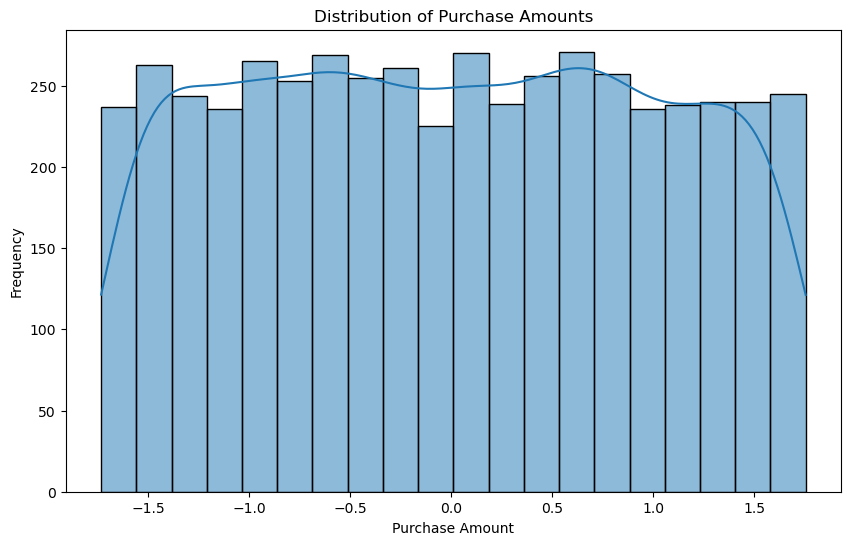

In [76]:
# Distribution of purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['Purchase_Amount'], bins=20, kde=True)
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

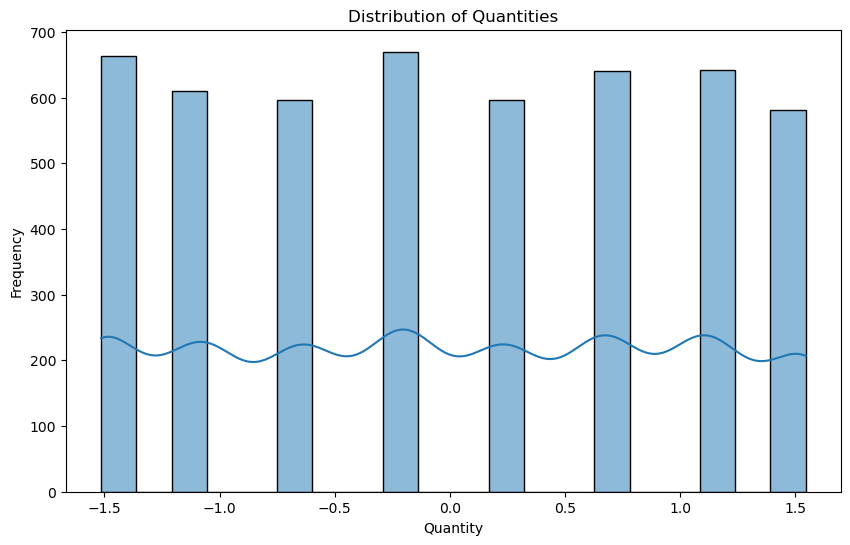

In [77]:
# Distribution of quantities
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['Quantity'], bins=20, kde=True)
plt.title('Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

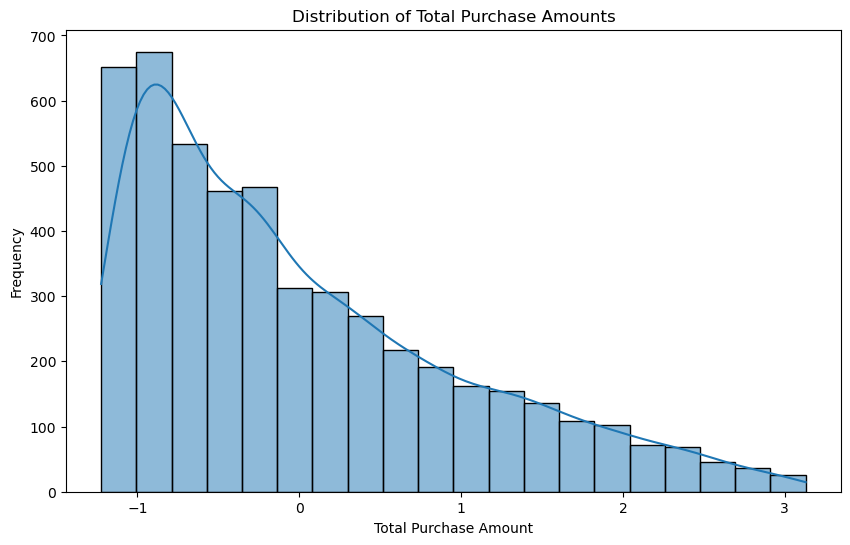

In [78]:
# Distribution of total purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['Total_Purchase_Amount'], bins=20, kde=True)
plt.title('Distribution of Total Purchase Amounts')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Frequency')
plt.show()

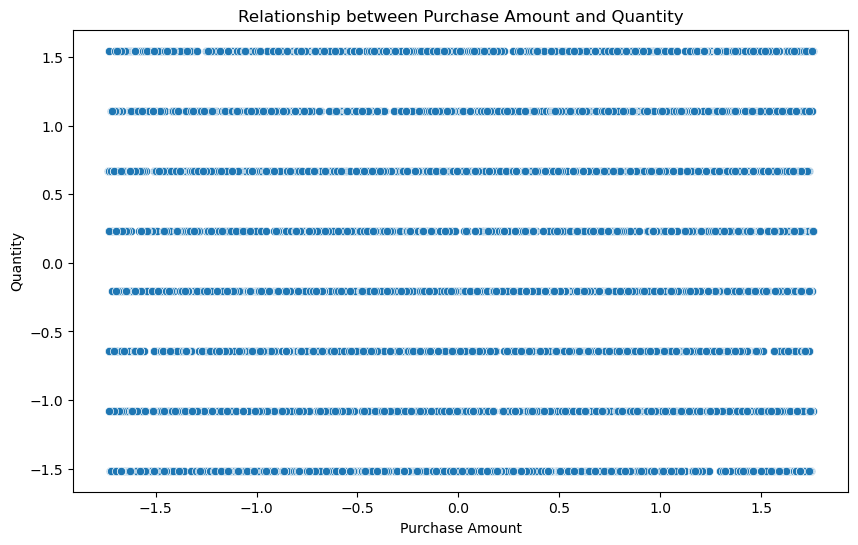

In [79]:
# Relationship between purchase amount and quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Purchase_Amount', y='Quantity', data=purchase_data)
plt.title('Relationship between Purchase Amount and Quantity')
plt.xlabel('Purchase Amount')
plt.ylabel('Quantity')
plt.show()

# Browsing Data

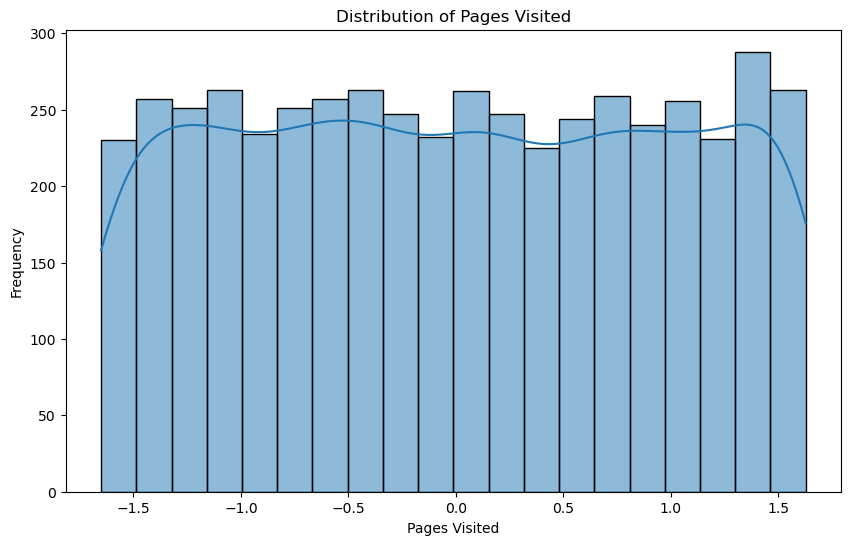

In [80]:

# Distribution of pages visited
plt.figure(figsize=(10, 6))
sns.histplot(browsing_data['Pages_Visited'], bins=20, kde=True)
plt.title('Distribution of Pages Visited')
plt.xlabel('Pages Visited')
plt.ylabel('Frequency')
plt.show()

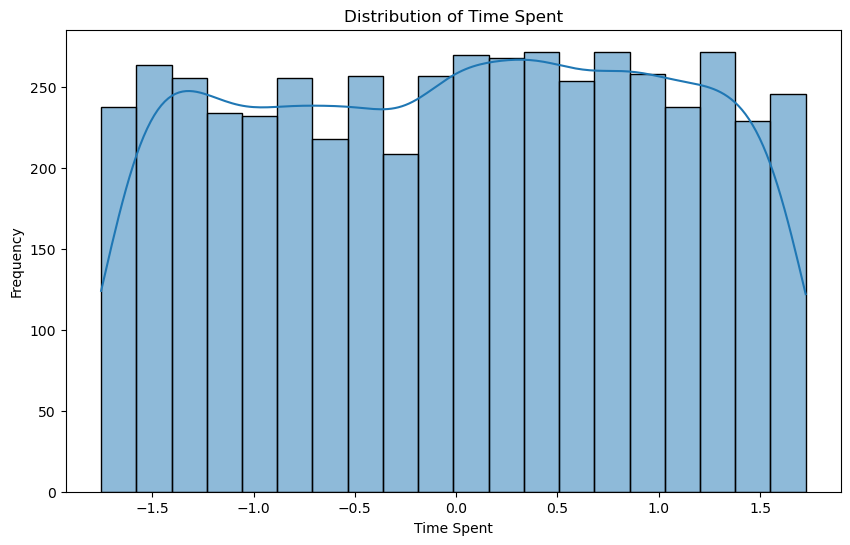

In [81]:
# Distribution of time spent
plt.figure(figsize=(10, 6))
sns.histplot(browsing_data['Time_Spent'], bins=20, kde=True)
plt.title('Distribution of Time Spent')
plt.xlabel('Time Spent')
plt.ylabel('Frequency')
plt.show()

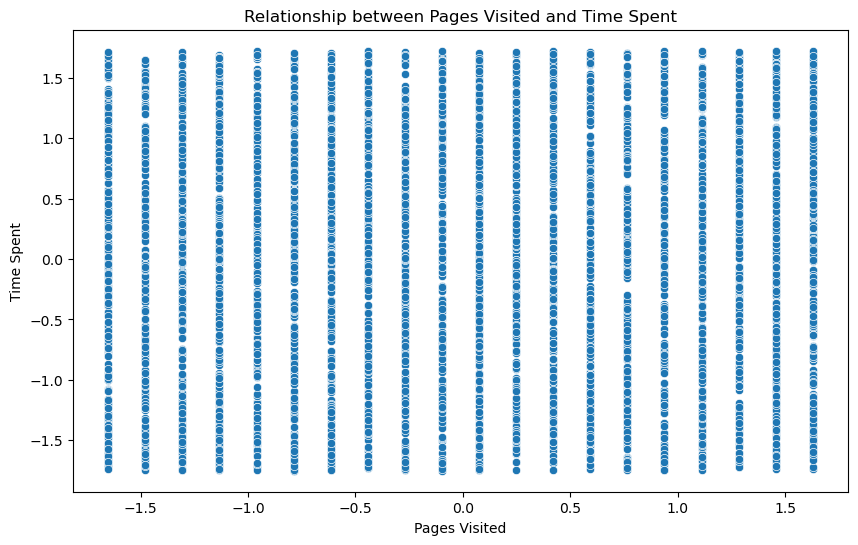

In [82]:
# Relationship between pages visited and time spent
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pages_Visited', y='Time_Spent', data=browsing_data)
plt.title('Relationship between Pages Visited and Time Spent')
plt.xlabel('Pages Visited')
plt.ylabel('Time Spent')
plt.show()

# Product Interactions Data

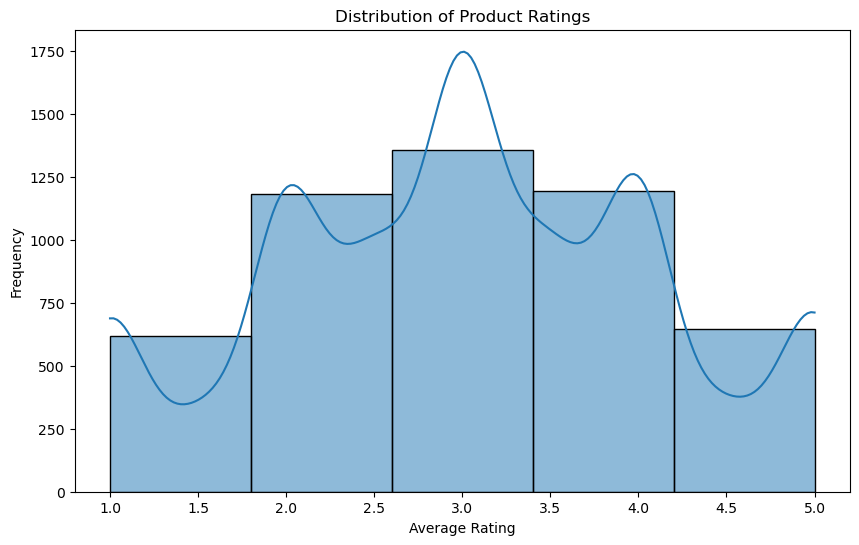

In [83]:
# Distribution of product ratings
plt.figure(figsize=(10, 6))
sns.histplot(product_interactions_data['Average_Rating'], bins=5, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

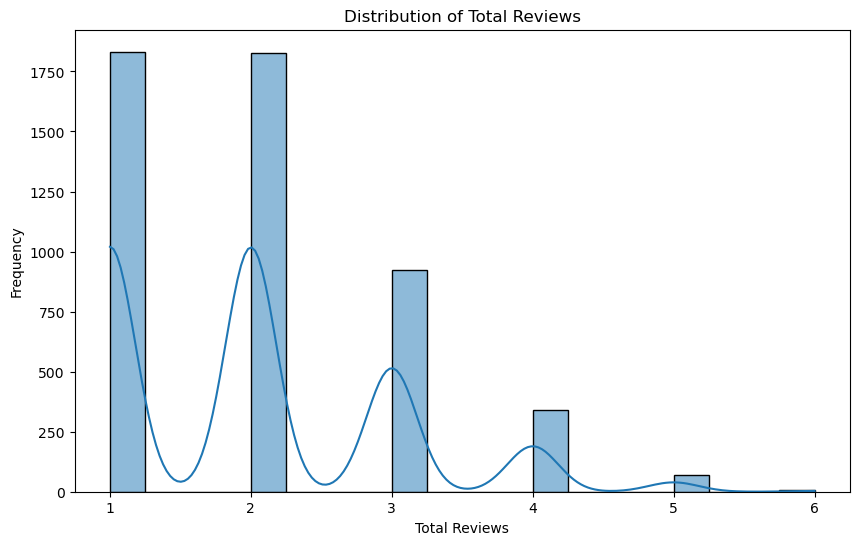

In [84]:
# Distribution of total reviews
plt.figure(figsize=(10, 6))
sns.histplot(product_interactions_data['Total_Reviews'], bins=20, kde=True)
plt.title('Distribution of Total Reviews')
plt.xlabel('Total Reviews')
plt.ylabel('Frequency')
plt.show()

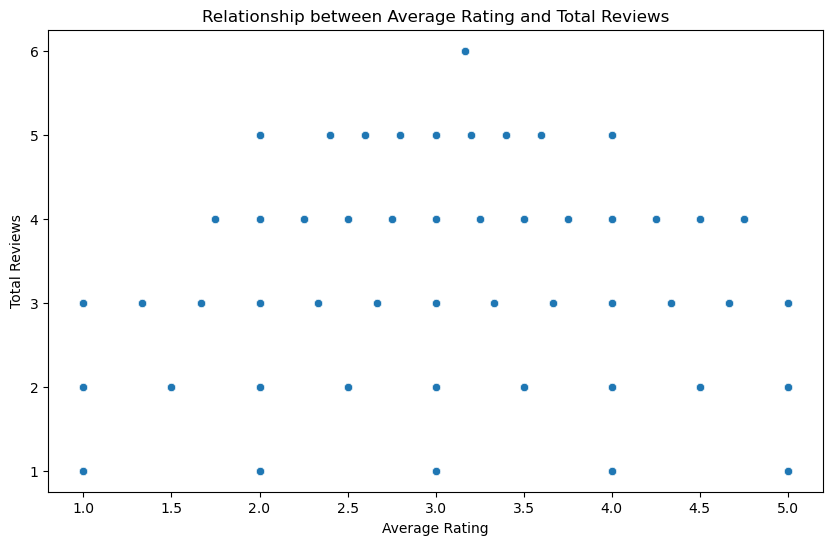

In [85]:
# Relationship between average rating and total reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Rating', y='Total_Reviews', data=product_interactions_data)
plt.title('Relationship between Average Rating and Total Reviews')
plt.xlabel('Average Rating')
plt.ylabel('Total Reviews')
plt.show()

# K-mean clustering for customer segmentation 

In [86]:

# Combine relevant features for clustering
X = purchase_data[['Total_Purchase_Amount', 'Average_Purchase_Amount']].values

# Determine the optimal number of clusters using the elbow method
inertia_values = []
silhouette_scores = []
max_clusters = 10  # Maximum number of clusters to consider
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

E:\Software Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Software Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Software Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Software Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

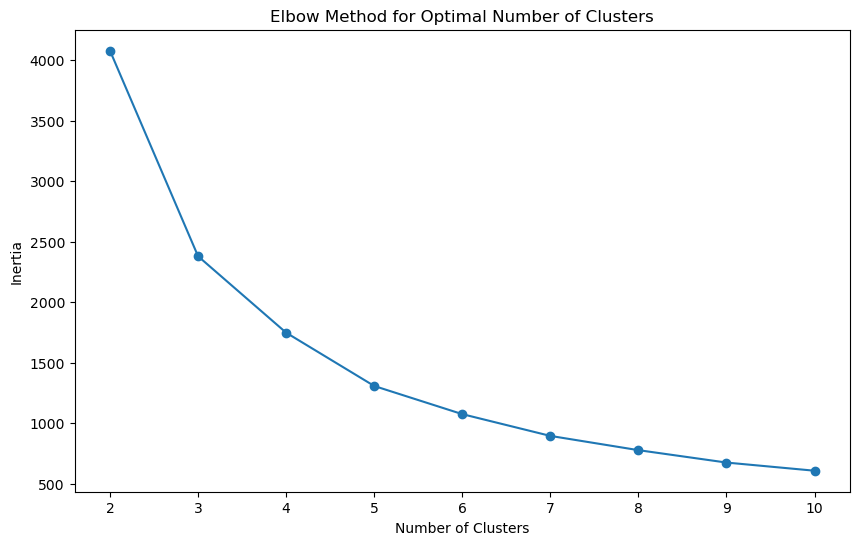

In [87]:
# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

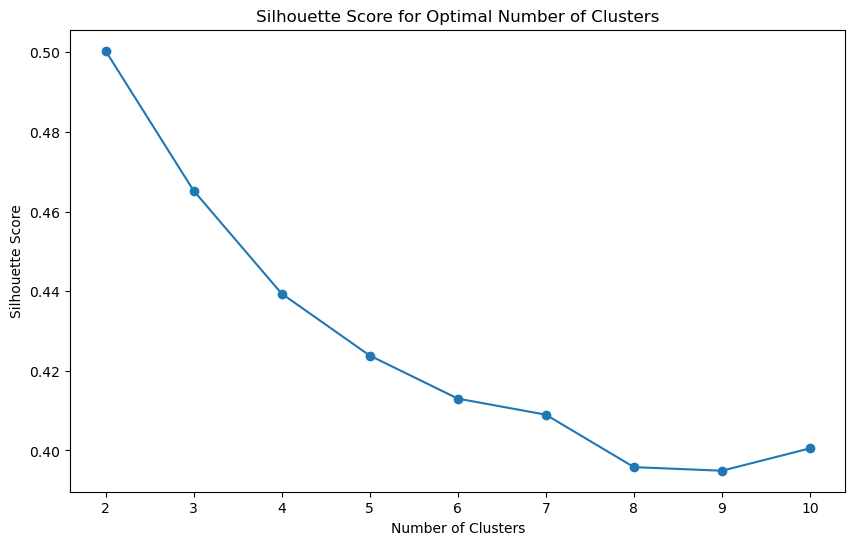

In [88]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [89]:
# Based on the elbow method and silhouette score, choose the optimal number of clusters
optimal_clusters = 3  # Adjust as needed

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

# Assign each customer to a segment based on their cluster membership
purchase_data['Segment_Kmeans'] = kmeans.labels_

# Display the segment assignments
print("Segment Assignments (K-means):")
purchase_data[['Customer_ID', 'Segment_Kmeans']].head()

E:\Software Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Segment Assignments (K-means):


,Customer_ID,Segment_Kmeans
0,601,0
1,4822,0
2,4988,2
3,4341,2
4,4050,2


# Hierarchical Clustering for customer segmentation

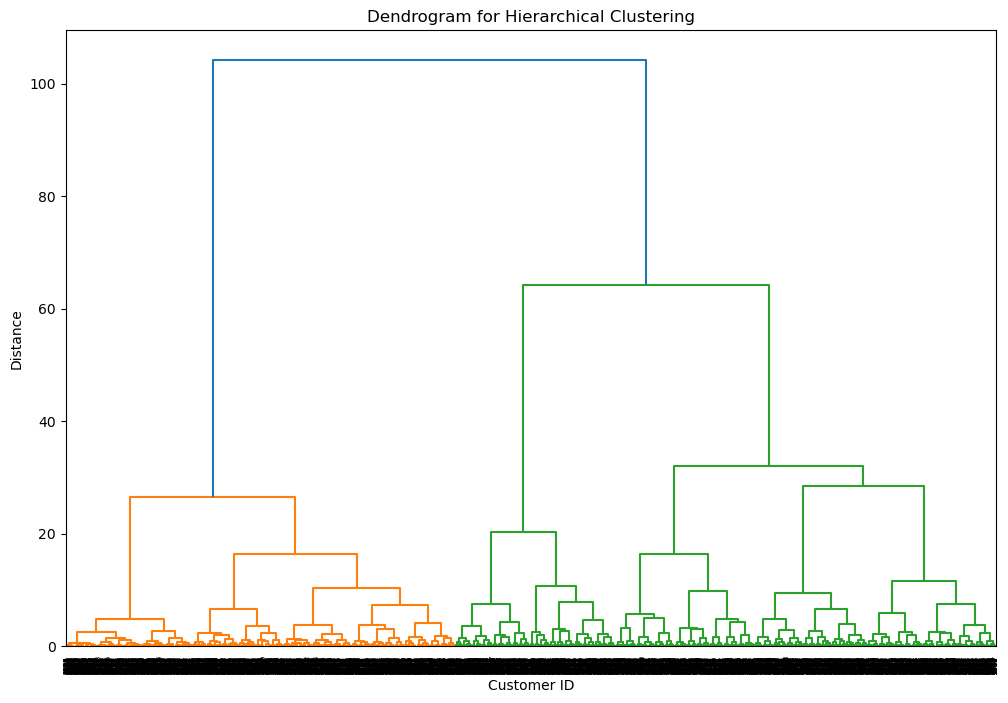

In [90]:


# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customer ID')
plt.ylabel('Distance')
plt.show()

In [91]:

# Choose the optimal number of clusters based on dendrogram
optimal_clusters_hierarchical = 3  # Adjust as needed

# Assign each customer to a segment based on hierarchical clustering
purchase_data['Segment_Hierarchical'] = fcluster(Z, optimal_clusters_hierarchical, criterion='maxclust')

# Display the segment assignments
print("\nSegment Assignments (Hierarchical Clustering):")
purchase_data[['Customer_ID', 'Segment_Hierarchical']].head()


Segment Assignments (Hierarchical Clustering):


,Customer_ID,Segment_Hierarchical
0,601,3
1,4822,3
2,4988,1
3,4341,1
4,4050,1


# Segment Profiling

In [92]:
# Segment Profiling for K-means Clustering
segment_profiles_kmeans = purchase_data.groupby('Segment_Kmeans').agg({
    'Customer_ID': 'count',
    'Total_Purchase_Amount': 'mean',
    'Average_Purchase_Amount': 'mean'
}).reset_index()

segment_profiles_kmeans.rename(columns={
    'Customer_ID': 'Customer_Count',
    'Total_Purchase_Amount': 'Average_Total_Purchase_Amount',
    'Average_Purchase_Amount': 'Average_Average_Purchase_Amount'
}, inplace=True)

print("Segment Profiles (K-means Clustering):")
print(segment_profiles_kmeans)

Segment Profiles (K-means Clustering):
   Segment_Kmeans  Customer_Count  Average_Total_Purchase_Amount  \
0               0            1961                      -0.040180   
1               1             988                       1.650386   
2               2            2051                      -0.756601   

   Average_Average_Purchase_Amount  
0                         0.506999  
1                         1.085745  
2                        -1.007772  


In [93]:
# Segment Profiling for Hierarchical Clustering
segment_profiles_hierarchical = purchase_data.groupby('Segment_Hierarchical').agg({
    'Customer_ID': 'count',
    'Total_Purchase_Amount': 'mean',
    'Average_Purchase_Amount': 'mean'
}).reset_index()

segment_profiles_hierarchical.rename(columns={
    'Customer_ID': 'Customer_Count',
    'Total_Purchase_Amount': 'Average_Total_Purchase_Amount',
    'Average_Purchase_Amount': 'Average_Average_Purchase_Amount'
}, inplace=True)

print("\nSegment Profiles (Hierarchical Clustering):")
print(segment_profiles_hierarchical)


Segment Profiles (Hierarchical Clustering):
   Segment_Hierarchical  Customer_Count  Average_Total_Purchase_Amount  \
0                     1            2094                      -0.716013   
1                     2             860                       1.759337   
2                     3            2046                      -0.006695   

   Average_Average_Purchase_Amount  
0                        -0.998861  
1                         1.096373  
2                         0.561454  


# Recommendation System Model with Singular Value Decomposition (Turncated)

In [94]:

# Prepare the historical data on customer-product interactions
X = product_interactions_data.pivot(index='Customer_ID', columns='Product_ID', values='Rating').fillna(0)

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Train the recommendation model using TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
predictions = svd.inverse_transform(X_test_svd)
rmse = mean_squared_error(X_test, predictions, squared=False)
print("RMSE (Root Mean Squared Error):", rmse)

RMSE (Root Mean Squared Error): 0.02417225033405788


In [95]:
# Generate recommendations for a sample customer
sample_customer_id = 1509  # Adjust as needed
sample_customer_index = X.index.get_loc(sample_customer_id)
predicted_ratings = svd.inverse_transform(X_train_svd)[sample_customer_index]
top_recommendations = sorted(list(enumerate(predicted_ratings)), key=lambda x: x[1], reverse=True)[:10]
print("\nRecommendations for Customer", sample_customer_id, ":")
for product_index, predicted_rating in top_recommendations:
    product_id = X.columns[product_index]
    print("Product ID:", product_id, "| Predicted Rating:", predicted_rating)


Recommendations for Customer 1509 :
Product ID: 1164 | Predicted Rating: 1.2043170726929087e-11
Product ID: 2438 | Predicted Rating: 1.2043170726929087e-11
Product ID: 4599 | Predicted Rating: 1.2043170726929087e-11
Product ID: 821 | Predicted Rating: 1.0079950936377117e-11
Product ID: 1003 | Predicted Rating: 1.0079950936377117e-11
Product ID: 3767 | Predicted Rating: 1.0079950936377117e-11
Product ID: 3359 | Predicted Rating: 8.754941751120746e-12
Product ID: 3644 | Predicted Rating: 8.754941751120746e-12
Product ID: 2069 | Predicted Rating: 7.003953400896593e-12
Product ID: 4738 | Predicted Rating: 7.003953400896593e-12


# Evaluation

In [96]:

# Prepare data for evaluation
X_eval = product_interactions_data.pivot(index='Customer_ID', columns='Product_ID', values='Rating').fillna(0)

# Initialize evaluation metrics
precision_scores = []
recall_scores = []
average_precision_scores = []

# Perform K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_eval):
    X_train_eval, X_test_eval = X_eval.iloc[train_index], X_eval.iloc[test_index]
    
    # Train the recommendation model using TruncatedSVD
    svd_eval = TruncatedSVD(n_components=10, random_state=42)
    X_train_svd_eval = svd_eval.fit_transform(X_train_eval)
    X_test_svd_eval = svd_eval.transform(X_test_eval)
    
    # Generate recommendations for test set
    predictions_eval = svd_eval.inverse_transform(X_test_svd_eval)
    
    # Flatten the predictions and true ratings
    predictions_flat = predictions_eval.flatten()
    true_ratings_flat = X_test_eval.values.flatten()
    
    # Calculate precision, recall, and average precision
    # Calculate precision, recall, and average precision
    precision = precision_score(true_ratings_flat > 0, predictions_flat > 0, average='binary')
    recall = recall_score(true_ratings_flat > 0, predictions_flat > 0, average='binary')
    
    # Reshape arrays for average_precision_score
    true_ratings_flat = true_ratings_flat.reshape(-1, 1)
    predictions_flat = predictions_flat.reshape(-1, 1)
    average_precision = average_precision_score(true_ratings_flat, predictions_flat)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    average_precision_scores.append(average_precision)

# Calculate average evaluation metrics
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_avg_precision = sum(average_precision_scores) / len(average_precision_scores)

# Display evaluation results
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average Mean Average Precision:", avg_avg_precision)

Average Precision: 0.0005022660041693148
Average Recall: 0.0037976178468550293
Average Mean Average Precision: 0.9996829330642034
